## 0. Set up


### 라이브러리 세팅

In [1]:
# 필요한 라이브러리 설치
%pip install openpyxl   # 엑셀 파일 쓰기 위한 라이브러리
%pip install eli5==0.13.0  # 변수 중요도 확인 위한 라이브러리   
%pip install category-encoders  # 범주형 변수 인코딩 위한 라이브러리
!apt-get install -y fonts-nanum  # 한글 폰트 설치

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


In [3]:
# 필요한 라이브러리 불러오기
# utils
import os
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')


# 전처리
from scipy.special import boxcox1p
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder, CountEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml



# visualization
import pprint
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')
from tqdm.auto import tqdm


# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### 데이터 로드

In [8]:
# 필요한 데이터를 load 하기
# 경로는 환경에 맞게 지정
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
subway_path = '/data/ephemeral/home/subway_feature.csv'
bus_path = '/data/ephemeral/home/bus_feature.csv'

dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
subway_dt = pd.read_csv(subway_path)
bus_dt = pd.read_csv(bus_path)


### 데이터 구조 확인

In [15]:
# 데이터 전체 구조 확인

# train data
print("=== Training Dataset (dt) ===")
display(dt.shape)
display(dt.info())
display(dt.head(1))
print("\n\n")
# test data
print("=== Test Dataset (dt_test) ===")
display(dt_test.shape)
display(dt_test.info())
display(dt_test.head(1))
print("\n\n")

# subway data
print("=== Subway Dataset (subway_dt) ===")
display(subway_dt.shape)
display(subway_dt.info())
display(subway_dt.head(1))
print("\n\n")

# bus data
print("=== Bus Dataset (bus_dt) ===")
display(bus_dt.shape)   
display(bus_dt.info())
display(bus_dt.head(1))
print("\n\n")

=== Training Dataset (dt) ===


(1118822, 52)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

None

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000





=== Test Dataset (dt_test) ===


(9272, 51)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9270 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9262 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   

None

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0





=== Subway Dataset (subway_dt) ===


(768, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   역사_ID   768 non-null    int64  
 1   역사명     768 non-null    object 
 2   호선      768 non-null    object 
 3   위도      768 non-null    float64
 4   경도      768 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 30.1+ KB


None

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877





=== Bus Dataset (bus_dt) ===


(12584, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12584 entries, 0 to 12583
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   노드 ID   12584 non-null  int64  
 1   정류소번호   12584 non-null  int64  
 2   정류소명    12584 non-null  object 
 3   X좌표     12584 non-null  float64
 4   Y좌표     12584 non-null  float64
 5   정류소 타입  12584 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 590.0+ KB


None

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


## 1 전처리


### 1-1. Drop 변수 정리



In [4]:
## 1-1 Feature 별 데이터 통계치 확인  (오래 걸림))

# 1. 통계치 확인
for column in dt.columns:
    display(f"{column} 데이터 통계치")
    display(f"{len(dt[column].unique())} unique values")
    display(f"결측치 수: {dt.isna().sum()[column]}")
    display(dt[column].describe())
    print("\n")

'시군구 데이터 통계치'

'339 unique values'

'결측치 수: 0'

count           1118822
unique              339
top       서울특별시 노원구 상계동
freq              44948
Name: 시군구, dtype: object

'번지 데이터 통계치'

'6573 unique values'

'결측치 수: 225'

count     1118597
unique       6572
top            13
freq         4629
Name: 번지, dtype: object

'본번 데이터 통계치'

'1524 unique values'

'결측치 수: 75'

count    1.118747e+06
mean     5.649108e+02
std      5.160642e+02
min      0.000000e+00
25%      1.760000e+02
50%      4.700000e+02
75%      7.810000e+02
max      4.974000e+03
Name: 본번, dtype: float64

'부번 데이터 통계치'

'330 unique values'

'결측치 수: 75'

count    1.118747e+06
mean     5.978885e+00
std      4.668584e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.837000e+03
Name: 부번, dtype: float64

'아파트명 데이터 통계치'

'6539 unique values'

'결측치 수: 2126'

count     1116696
unique       6538
top            현대
freq        16644
Name: 아파트명, dtype: object

'전용면적(㎡) 데이터 통계치'

'14617 unique values'

'결측치 수: 0'

count    1.118822e+06
mean     7.717475e+01
std      2.936423e+01
min      1.002000e+01
25%      5.965000e+01
50%      8.188000e+01
75%      8.496000e+01
max      4.243200e+02
Name: 전용면적(㎡), dtype: float64

'계약년월 데이터 통계치'

'198 unique values'

'결측치 수: 0'

count    1.118822e+06
mean     2.014760e+05
std      4.187868e+02
min      2.007010e+05
25%      2.011100e+05
50%      2.015070e+05
75%      2.018040e+05
max      2.023060e+05
Name: 계약년월, dtype: float64

'계약일 데이터 통계치'

'31 unique values'

'결측치 수: 0'

count    1.118822e+06
mean     1.580656e+01
std      8.721166e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.600000e+01
75%      2.300000e+01
max      3.100000e+01
Name: 계약일, dtype: float64

'층 데이터 통계치'

'73 unique values'

'결측치 수: 0'

count    1.118822e+06
mean     8.871968e+00
std      5.982584e+00
min     -4.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.200000e+01
max      6.900000e+01
Name: 층, dtype: float64

'건축년도 데이터 통계치'

'60 unique values'

'결측치 수: 0'

count    1.118822e+06
mean     1.998755e+03
std      9.333908e+00
min      1.961000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

'도로명 데이터 통계치'

'9232 unique values'

'결측치 수: 0'

count      1118822
unique        9232
top       올림픽로 435
freq          4322
Name: 도로명, dtype: object

'해제사유발생일 데이터 통계치'

'1026 unique values'

'결측치 수: 1112839'

count    5.983000e+03
mean     2.021057e+07
std      1.060697e+04
min      2.020022e+07
25%      2.020082e+07
50%      2.021030e+07
75%      2.022021e+07
max      2.023093e+07
Name: 해제사유발생일, dtype: float64

'등기신청일자 데이터 통계치'

'182 unique values'

'결측치 수: 0'

count     1118822
unique        182
top              
freq      1103907
Name: 등기신청일자, dtype: object

'거래유형 데이터 통계치'

'3 unique values'

'결측치 수: 0'

count     1118822
unique          3
top             -
freq      1086451
Name: 거래유형, dtype: object

'중개사소재지 데이터 통계치'

'643 unique values'

'결측치 수: 0'

count     1118822
unique        643
top             -
freq      1089581
Name: 중개사소재지, dtype: object

'k-단지분류(아파트,주상복합등등) 데이터 통계치'

'6 unique values'

'결측치 수: 870691'

count     248131
unique         5
top          아파트
freq      235994
Name: k-단지분류(아파트,주상복합등등), dtype: object

'k-전화번호 데이터 통계치'

'1082 unique values'

'결측치 수: 870274'

count        248548
unique         1081
top       024162883
freq           3028
Name: k-전화번호, dtype: object

'k-팩스번호 데이터 통계치'

'1365 unique values'

'결측치 수: 872742'

count          246080
unique           1364
top       02-572-3212
freq             2816
Name: k-팩스번호, dtype: object

'단지소개기존clob 데이터 통계치'

'95 unique values'

'결측치 수: 1050240'

count    68582.000000
mean       541.529979
std        751.809853
min          1.000000
25%          4.000000
50%        174.000000
75%        725.000000
max       2888.000000
Name: 단지소개기존clob, dtype: float64

'k-세대타입(분양형태) 데이터 통계치'

'4 unique values'

'결측치 수: 869563'

count     249259
unique         3
top           분양
freq      206371
Name: k-세대타입(분양형태), dtype: object

'k-관리방식 데이터 통계치'

'4 unique values'

'결측치 수: 869563'

count     249259
unique         3
top         위탁관리
freq      227842
Name: k-관리방식, dtype: object

'k-복도유형 데이터 통계치'

'6 unique values'

'결측치 수: 869890'

count     248932
unique         5
top          계단식
freq      123651
Name: k-복도유형, dtype: object

'k-난방방식 데이터 통계치'

'5 unique values'

'결측치 수: 869563'

count     249259
unique         4
top         개별난방
freq      150739
Name: k-난방방식, dtype: object

'k-전체동수 데이터 통계치'

'42 unique values'

'결측치 수: 870630'

count    248192.000000
mean         14.798346
std          17.693533
min           1.000000
25%           5.000000
50%          10.000000
75%          17.000000
max         124.000000
Name: k-전체동수, dtype: float64

'k-전체세대수 데이터 통계치'

'522 unique values'

'결측치 수: 869563'

count    249259.000000
mean       1184.124593
std        1191.474680
min          59.000000
25%         403.000000
50%         768.000000
75%        1622.000000
max        9510.000000
Name: k-전체세대수, dtype: float64

'k-건설사(시공사) 데이터 통계치'

'345 unique values'

'결측치 수: 871058'

count     247764
unique       344
top         삼성물산
freq       14081
Name: k-건설사(시공사), dtype: object

'k-시행사 데이터 통계치'

'556 unique values'

'결측치 수: 871254'

count     247568
unique       555
top         SH공사
freq       12495
Name: k-시행사, dtype: object

'k-사용검사일-사용승인일 데이터 통계치'

'674 unique values'

'결측치 수: 869696'

count                    249126
unique                      673
top       1992-11-18 00:00:00.0
freq                       3277
Name: k-사용검사일-사용승인일, dtype: object

'k-연면적 데이터 통계치'

'735 unique values'

'결측치 수: 869563'

count    2.492590e+05
mean     1.614967e+05
std      1.839856e+05
min      0.000000e+00
25%      5.366600e+04
50%      1.016330e+05
75%      2.039040e+05
max      9.591851e+06
Name: k-연면적, dtype: float64

'k-주거전용면적 데이터 통계치'

'740 unique values'

'결측치 수: 869608'

count    249214.000000
mean      94210.104998
std      101905.956897
min        2338.000000
25%       31934.000000
50%       60280.000000
75%      117086.000000
max      734781.000000
Name: k-주거전용면적, dtype: float64

'k-관리비부과면적 데이터 통계치'

'736 unique values'

'결측치 수: 869563'

count    249259.000000
mean     120726.487549
std      129020.276480
min           0.000000
25%       40735.000000
50%       78125.000000
75%      159544.000000
max      969877.000000
Name: k-관리비부과면적, dtype: float64

'k-전용면적별세대현황(60㎡이하) 데이터 통계치'

'349 unique values'

'결측치 수: 869608'

count    249214.000000
mean        477.912838
std         759.909400
min           0.000000
25%          48.000000
50%         225.000000
75%         576.000000
max        4975.000000
Name: k-전용면적별세대현황(60㎡이하), dtype: float64

'k-전용면적별세대현황(60㎡~85㎡이하) 데이터 통계치'

'388 unique values'

'결측치 수: 869608'

count    249214.000000
mean        476.713439
std         727.553569
min           0.000000
25%          95.000000
50%         256.000000
75%         582.000000
max        5132.000000
Name: k-전용면적별세대현황(60㎡~85㎡이하), dtype: float64

'k-85㎡~135㎡이하 데이터 통계치'

'245 unique values'

'결측치 수: 869608'

count    249214.000000
mean        167.528470
std         248.928143
min           0.000000
25%           0.000000
50%          63.000000
75%         237.000000
max        1500.000000
Name: k-85㎡~135㎡이하, dtype: float64

'k-135㎡초과 데이터 통계치'

'2 unique values'

'결측치 수: 1118495'

count    327.0
mean      70.0
std        0.0
min       70.0
25%       70.0
50%       70.0
75%       70.0
max       70.0
Name: k-135㎡초과, dtype: float64

'k-홈페이지 데이터 통계치'

'222 unique values'

'결측치 수: 1005647'

count     113175
unique       221
top           없음
freq        3606
Name: k-홈페이지, dtype: object

'k-등록일자 데이터 통계치'

'127 unique values'

'결측치 수: 1107832'

count                     10990
unique                      126
top       2017-02-01 10:49:21.0
freq                       1857
Name: k-등록일자, dtype: object

'k-수정일자 데이터 통계치'

'744 unique values'

'결측치 수: 869608'

count                    249214
unique                      743
top       2023-09-20 21:38:55.0
freq                       3028
Name: k-수정일자, dtype: object

'고용보험관리번호 데이터 통계치'

'527 unique values'

'결측치 수: 913304'

count             205518
unique               526
top       909-01-23103-1
freq                3028
Name: 고용보험관리번호, dtype: object

'경비비관리형태 데이터 통계치'

'5 unique values'

'결측치 수: 870988'

count     247834
unique         4
top           위탁
freq      206401
Name: 경비비관리형태, dtype: object

'세대전기계약방법 데이터 통계치'

'3 unique values'

'결측치 수: 878747'

count     240075
unique         2
top         종합계약
freq      122973
Name: 세대전기계약방법, dtype: object

'청소비관리형태 데이터 통계치'

'5 unique values'

'결측치 수: 871178'

count     247644
unique         4
top           위탁
freq      225016
Name: 청소비관리형태, dtype: object

'건축면적 데이터 통계치'

'456 unique values'

'결측치 수: 869714'

count    2.491080e+05
mean     1.895070e+05
std      1.729027e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.710550e+03
75%      8.414210e+03
max      3.159620e+07
Name: 건축면적, dtype: float64

'주차대수 데이터 통계치'

'527 unique values'

'결측치 수: 869714'

count    249108.000000
mean       1063.678778
std        1235.437604
min           0.000000
25%         315.000000
50%         683.000000
75%        1274.000000
max       12096.000000
Name: 주차대수, dtype: float64

'기타/의무/임대/임의=1/2/3/4 데이터 통계치'

'5 unique values'

'결측치 수: 869563'

count     249259
unique         4
top           의무
freq      239198
Name: 기타/의무/임대/임의=1/2/3/4, dtype: object

'단지승인일 데이터 통계치'

'736 unique values'

'결측치 수: 870286'

count                    248536
unique                      735
top       2013-06-23 12:47:34.0
freq                       3028
Name: 단지승인일, dtype: object

'사용허가여부 데이터 통계치'

'2 unique values'

'결측치 수: 869563'

count     249259
unique         1
top            Y
freq      249259
Name: 사용허가여부, dtype: object

'관리비 업로드 데이터 통계치'

'3 unique values'

'결측치 수: 869563'

count     249259
unique         2
top            N
freq      245117
Name: 관리비 업로드, dtype: object

'좌표X 데이터 통계치'

'742 unique values'

'결측치 수: 869670'

count    249152.000000
mean        126.995228
std           0.091045
min         126.798318
25%         126.913157
50%         127.014971
75%         127.059590
max         127.179998
Name: 좌표X, dtype: float64

'좌표Y 데이터 통계치'

'742 unique values'

'결측치 수: 869670'

count    249152.000000
mean         37.545785
std           0.052483
min          37.447843
25%          37.499201
50%          37.544936
75%          37.577117
max          37.687725
Name: 좌표Y, dtype: float64

'단지신청일 데이터 통계치'

'260 unique values'

'결측치 수: 869625'

count                    249197
unique                      259
top       2013-03-07 09:46:18.0
freq                      16435
Name: 단지신청일, dtype: object

'target 데이터 통계치'

'14530 unique values'

'결측치 수: 0'

count    1.118822e+06
mean     5.799153e+04
std      4.642602e+04
min      3.500000e+02
25%      3.050000e+04
50%      4.480000e+04
75%      6.980000e+04
max      1.450000e+06
Name: target, dtype: float64

In [9]:
# 제외 변수 (feature 분석용
except_col = ['번지', '본번', '부번', '도로명', '해지사유발생일',
              '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 
              'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 
              'k-난방방식','k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
              'k-관리비부과면적', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', 
              '고용보험관리번호', '경비관리형태', '세대전기계약방법', '청소비관리형태',
              '단지승인일', '사용허가여부', '관리비 업로드','단지신청일']

# 날짜 변수 (type 무관)
date_col = ['계약년월', '계약일', '건축년도', '해제사유발생일', '등기신청일자', 'k-사용검사일-사용승인일', 'k-등록일자', 'k-수정일자', '단지승인일', '단지신청일']


# 실수형 변수 
def num_col(except_col, date_col):
    return [col for col in dt.select_dtypes('float64').columns if col not in except_col + date_col]
display(f"실수형 변수 개수: {len(num_col(except_col, date_col))}")
display(", ".join(num_col(except_col, date_col)))

# 범주형 변수
def cat_col(except_col, date_col):
    return [col for col in dt.select_dtypes('object').columns if col not in except_col + date_col]
display(f"범주형 변수 개수: {len(cat_col(except_col, date_col))}")
display(", ".join(cat_col(except_col, date_col)))

# 정수형 변수
def int_col(except_col, date_col):
    return [col for col in dt.select_dtypes('int64').columns if col not in except_col + date_col]
display(f"정수형 변수 개수: {len(int_col(except_col, date_col))}")
display(", ".join(int_col(except_col, date_col)))


'실수형 변수 개수: 12'

'전용면적(㎡), k-전체동수, k-전체세대수, k-연면적, k-주거전용면적, k-전용면적별세대현황(60㎡이하), k-전용면적별세대현황(60㎡~85㎡이하), k-85㎡~135㎡이하, 건축면적, 주차대수, 좌표X, 좌표Y'

'범주형 변수 개수: 6'

'시군구, 아파트명, k-단지분류(아파트,주상복합등등), k-세대타입(분양형태), 경비비관리형태, 기타/의무/임대/임의=1/2/3/4'

'정수형 변수 개수: 2'

'층, target'

In [ ]:
# 위의 제외 변수(except_col) 제거
dt.drop(columns=except_col, axis=1, inplace=True)

### 1-2. 파생변수 생성


In [10]:
# '시군구' column을 '시', '군', '구' 3개의 새로운 열로 분리
dt[['시', '군', '구']] = dt['시군구'].str.split(expand=True, n=2)

# # 원래 '시군구' 열은 필요 없으므로 삭제
# dt.drop(columns=['시군구'], inplace=True)

# 시, 군, 구 확인
display(dt[['시', '군', '구']].head())

,시,군,구
0,서울특별시,강남구,개포동
1,서울특별시,강남구,개포동
2,서울특별시,강남구,개포동
3,서울특별시,강남구,개포동
4,서울특별시,강남구,개포동


In [11]:
display(dt[['계약년월', '계약일']].head())

# 계약년월 문자열로 변환
dt['계약년월'] = dt['계약년월'].astype(str)
# 계약년, 계약월 변수 생성
dt['계약년'] = dt['계약년월'].str[:4]
dt['계약월'] = dt['계약년월'].str[4:]

display(dt[['계약년월', '계약년', '계약월']].head())

# # 계약년월 변수 제거
# dt.drop(columns=['계약년월'], inplace=True)


,계약년월,계약일
0,201712,8
1,201712,22
2,201712,28
3,201801,3
4,201801,8


,계약년월,계약년,계약월
0,201712,2017,12
1,201712,2017,12
2,201712,2017,12
3,201801,2018,01
4,201801,2018,01


In [29]:
# 주거전용면적비율 파생변수 추가
dt['주거전용면적비율'] = dt['k-주거전용면적'] / dt['k-연면적']

# # 주거전용면적 변수 제거
# dt.drop(columns=['주거전용면적'], inplace=True)

display(dt[['k-주거전용면적', 'k-연면적', '주거전용면적비율']].head(5))
display(dt[['k-주거전용면적', 'k-연면적', '주거전용면적비율']].describe())
display(dt[['k-주거전용면적', 'k-연면적', '주거전용면적비율']].info())

# 아파트명 별 주거전용면적비율 평균
avg_ratio = dt.groupby('아파트명')['주거전용면적비율'].mean()
avg_ratio_df = pd.DataFrame(avg_ratio).sort_values('주거전용면적비율', ascending=False)
display(avg_ratio_df.head(20))  


,k-주거전용면적,k-연면적,주거전용면적비율
0,20204.0,22637.0,0.892521
1,20204.0,22637.0,0.892521
2,20204.0,22637.0,0.892521
3,20204.0,22637.0,0.892521
4,20204.0,22637.0,0.892521


,k-주거전용면적,k-연면적,주거전용면적비율
count,249214.000000,2.492590e+05,2.492140e+05
mean,94210.104998,1.614967e+05,inf
std,101905.956897,1.839856e+05,NaN
min,2338.000000,0.000000e+00,4.856310e-03
25%,31934.000000,5.366600e+04,5.197022e-01
50%,60280.000000,1.016330e+05,5.695177e-01
75%,117086.000000,2.039040e+05,6.708890e-01
max,734781.000000,9.591851e+06,inf


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   k-주거전용면적  249214 non-null  float64
 1   k-연면적     249259 non-null  float64
 2   주거전용면적비율  249214 non-null  float64
dtypes: float64(3)
memory usage: 25.6 MB


None

,주거전용면적비율
아파트명,
개포주공1단지,1.007613
산업인,1.000240
한남하이츠,0.921606
청담삼익,0.918232
남서울건영,0.915690
장안현대,0.902212
방배신삼호,0.901681
개포6차우성,0.892521
한양,0.878045


### 1-3. 범주형 변수 인코딩

In [ ]:
preprocessed_data = dt.copy()


In [ ]:
# One-Hot Encoding
OHE_col = ['']
for col in OHE_col:
    encoder = OneHotEncoder()
    onehot = encoder.fit_transform(preprocessed_data[[col]])
    # 배열형태로 전환
    onehot_array = onehot.toarray()
    display(f"{col} 고유 범주 수 : {len(preprocessed_data[col].unique())}")
    display(f"{col} 원-핫 인코딩의 차원 수 : {onehot_array.shape}")


In [ ]:
# Label Encoding
LE_col = ['k-단지분류(아파트, 주상복합등등)']

for col in LE_col:
    label_encoder = LabelEncoder()
    preprocessed_data[col] = label_encoder.fit_transform(preprocessed_data[col])
display(preprocessed_data.head())
display(f"레이블 인코딩의 범주 크기: {len(preprocessed_data[col].unique())}")
display(f"레이블 인코딩의 범주 범위: {preprocessed_data[col].min()} ~ {preprocessed_data[col].max()}")


In [ ]:
# Frequency Encoding
freq_col = ['시', '군', '구']

for col in freq_col:
    frequency_encoder = preprocessed_data[col].value_counts()
    preprocessed_data[f'FE_{col}'] = preprocessed_data[col].map(frequency_encoder)
display(preprocessed_data.head())

display(f"{col}의 인코딩 값: {preprocessed_data[preprocessed_data['아파트명'] == '**']['FE_아파트명'][0]}")


In [ ]:
# Target Encoding  --> 수정 필요 
# 단, target encoding은 평균을 낼 기준 변수가 필요함
TE_col = ['아파트명']

for col in TE_col:
    target_encoder = preprocessed_data.groupby(col)['target'].mean()
    preprocessed_data[f'TE_{col}'] = preprocessed_data[col].map(target_encoder)

display(preprocessed_data.head())


### 1.4 수치형 변수 처리

In [ ]:
# Log Transformation
Log_col = ['연면적']

for col in Log_col:
    preprocessed_data[f'Log_{col}'] = np.log1p(preprocessed_data[col])

display(preprocessed_data.describe())

# line plot 확인/scatter plot 확인/boxplot 확인
sns.lineplot(data=preprocessed_data, x='', y='', color='', marker='', s=80)
plt.show()


In [ ]:
# MinMax Scaling
MinMax_col = ['', '']

for col in MinMax_col:
    scaler = MinMaxScaler()
    preprocessed_data[f'MinMax_{col}'] = scaler.fit_transform(preprocessed_data[col])

display(preprocessed_data.describe())

# scatter plot 확인
sns.scatterplot(data=preprocessed_data, x='', y='', color='', marker='', s=80)
plt.show()

In [ ]:
# Standard Scaling
Std_col = ['', '']

for col in Std_col:
    scaler = StandardScaler()
    preprocessed_data[f'Std_{col}'] = scaler.fit_transform(preprocessed_data[col])

display(preprocessed_data.describe())

# scatter plot 확인
sns.scatterplot(data=preprocessed_data, x='', y='', color='', marker='', s=80)
plt.show()

In [ ]:
# Robust Scaling
Robust_col = ['', '']

for col in Robust_col:
    scaler = RobustScaler()
    preprocessed_data[f'Robust_{col}'] = scaler.fit_transform(preprocessed_data[col])

display(preprocessed_data.describe())  

# scatter plot 확인
sns.scatterplot(data=preprocessed_data, x='', y='', color='', marker='', s=80)
plt.show()

### 1-5. Binning 구간화

In [ ]:
# 연속형 변수의 구간화. 
# 각 feature 별로 구간화 개별 진행
# 변수 선택
bin_col = ['층']

# 구간 정의
bins = [0, 23, 46, 70]
labels = ['저층', '중층', '고층']

# 구간화 진행
preprocessed_data['층_bin'] = pd.cut(preprocessed_data['층'], bins=bins, labels=labels)

display(preprocessed_data.head())

In [ ]:
bin_col = ['주차대수']

# 구간 정의
bins = [0, 2000, 4000, 6000, 8000, 10000, 12096]
labels = ['주차1', '주차2', '주차3', '주차4', '주차5', '주차6']

# 구간화 진행
preprocessed_data['주차대수_bin'] = pd.cut(preprocessed_data['주차대수'], bins=bins, labels=labels)

display(preprocessed_data.head())

In [ ]:
bin_col = ['k-전체동수']   # 또는 전체세대수 (59~9,510)

# 구간 정의
bins = [0, 25, 50, 100, 125]
labels = ['소형', '중형', '대형', '초대형']

# 구간화 진행
preprocessed_data['k-전체동수_bin'] = pd.cut(preprocessed_data['k-전체동수'], bins=bins, labels=labels)

display(preprocessed_data.head())

## 2. 결측치 처리

### 2-1. 결측치 확인

In [6]:
# 결측치 확인
display(dt.isnull().sum())
display(dt.shape)


시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

(1118822, 52)

### 2-1 k-전체동수 결측치 처리

In [10]:
# 결측치 확인
# k-전체동수 null 값이 있으면서, 아파트명은 null 값이 아닌 경우 
# display(dt[dt['k-전체동수'].isna() & dt['아파트명'].notna()][['아파트명', 'k-전체동수']])
null_dong = dt[dt['k-전체동수'].isna()][['아파트명', 'k-전체동수']]
print("\n")
print(f"아파트명 w/ null k-전체동수: {len(null_dong.drop_duplicates('아파트명'))}")
display(null_dong.drop_duplicates('아파트명').sort_values('아파트명'))

print("\n")

# csv 저장
null_dong.to_csv('아파트명_null_k전체동수.csv', index=False, encoding='utf-8-sig')




아파트명 w/ null k-전체동수: 5862


,아파트명,k-전체동수
119370,153-25,NaN
756230,201호 미공시,NaN
72969,2차한양,NaN
55670,3RU-City,NaN
78511,3차신성미소지움,NaN
...,...,...
132398,힐튼,NaN
132333,힐튼빌리지1차,NaN
88182,힐튼빌리지2차,NaN
58080,힐하우스,NaN


In [51]:
# 대체 변수 생성
dt['k-전체동수_fill'] = (
    dt.groupby('아파트명')['k-전체동수']
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x)
)

# See the results and statistics
print(f"k-전체동수 null 값 수: {dt['k-전체동수'].isna().sum()}")
print(f"k-전체동수_fill null 값 수: {dt['k-전체동수_fill'].isna().sum()}")


k-전체동수 null 값 수: 870630
k-전체동수_fill null 값 수: 820427


In [31]:
display(dt[['아파트명', 'k-전체동수']].info())
display(dt[['아파트명', 'k-전체동수_fill']].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   아파트명    1116696 non-null  object 
 1   k-전체동수  248192 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   아파트명         1116696 non-null  object 
 1   k-전체동수_fill  298395 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.1+ MB


None

In [59]:
# null k-전체동수_fill 아파트 이름 모아 dataframe 만들기
null_apartments = dt[dt['k-전체동수_fill'].isna()]['아파트명'].unique()

print(f"null 보유 아파트 개수 : {len(null_apartments)}")
display(pd.DataFrame(null_apartments, columns=['아파트명']).sort_values('아파트명'))

# null k-전체동수_fill 값 보유 아파트 별 null 개수 모아 dataframe 만들기
null_counts = (
    dt[dt['k-전체동수_fill'].isna()]
    .groupby(['아파트명', '도로명'])
    .size()
    .sort_values(ascending=False)
    .reset_index(name='null_count')
)

print("\nDetailed count of null values per apartment:")
display(null_counts)

# Optionally save to CSV
null_counts.to_csv('apartments_with_null_k전체동수_fill_counts.csv', encoding='utf-8-sig')

null 보유 아파트 개수 : 5810


,아파트명
4409,153-25
5768,201호 미공시
3122,2차한양
2396,3RU-City
3268,3차신성미소지움
...,...
4556,힐튼
4554,힐튼빌리지1차
3692,힐튼빌리지2차
2541,힐하우스


AttributeError: 'DataFrameGroupBy' object has no attribute 'sort_values'

In [49]:
dt['k-전체세대수_fill'] = dt.groupby('아파트명')['k-전체세대수'].transform(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else x))
display(dt[['아파트명', 'k-전체세대수', 'k-전체세대수_fill']].info())

# Verify results
print("Null values before:", dt['k-전체세대수'].isna().sum())
print("Null values after:", dt['k-전체세대수_fill'].isna().sum())
display(dt[['아파트명', 'k-전체세대수', 'k-전체세대수_fill']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   아파트명          1116696 non-null  object 
 1   k-전체세대수       249259 non-null   float64
 2   k-전체세대수_fill  299480 non-null   float64
dtypes: float64(2), object(1)
memory usage: 25.6+ MB


None

Null values before: 869563
Null values after: 819342


,아파트명,k-전체세대수,k-전체세대수_fill
0,개포6차우성,270.0,270.0
1,개포6차우성,270.0,270.0
2,개포6차우성,270.0,270.0
3,개포6차우성,270.0,270.0
4,개포6차우성,270.0,270.0


In [32]:
# Check if same apartment names have consistent k-전체동수 values
apartment_buildings = dt.groupby('아파트명')['k-전체동수'].agg(['unique', 'count'])
consistent_values = apartment_buildings['unique'].apply(lambda x: len(x) == 1)

print("Apartments with consistent k-전체동수 values:", sum(consistent_values))
print("\nAll inconsistent cases:")
display(apartment_buildings[~consistent_values])
# Save to CSV
apartment_buildings[~consistent_values].to_csv('inconsistent_apartments.csv', encoding='utf-8-sig')

Apartments with consistent k-전체동수 values: 6485

All inconsistent cases:


,unique,count
아파트명,,
DMC아이파크,"[5.0, nan]",253
강남한양수자인,"[26.0, nan]",357
강변,"[nan, 4.0]",251
강변힐스테이트,"[7.0, nan]",394
경남아너스빌,"[nan, 5.0, 4.0]",433
경향렉스빌,"[2.0, nan]",173
공덕자이,"[nan, 2.0]",30
금호베스트빌,"[nan, 1.0]",396
대상,"[nan, 2.0]",242


In [37]:
# 아파트명 고유값 개수
display(len(dt['아파트명'].unique()))
# Check if same apartment names have consistent k-전체동수 values
apartment_buildings = dt.groupby('아파트명')['k-전체동수_fill'].agg(['unique', 'count'])
consistent_values = apartment_buildings['unique'].apply(lambda x: len(x) == 1)

print("Apartments with consistent k-전체동수_fill values:", sum(consistent_values))
print("\nAll inconsistent cases:")
display(apartment_buildings[~consistent_values])
# Save to CSV
apartment_buildings[~consistent_values].to_csv('inconsistent_apartments.csv', encoding='utf-8-sig')

6539

Apartments with consistent k-전체동수_fill values: 6538

All inconsistent cases:


,unique,count
아파트명,,


In [ ]:
apartment_buildings = dt.groupby('아파트명')['k-전체동수_fill'].agg(['unique', 'count'])
consistent_values = apartment_buildings['unique'].apply(lambda x: len(x) == 1)

print("Apartments with consistent k-전체동수_fill values:", sum(consistent_values))
print("\nAll inconsistent cases:")
display(apartment_buildings[~consistent_values])


Apartments with consistent k-전체동수_fill values: 6538

All inconsistent cases:


,unique,count
아파트명,,


In [40]:
# Get unique apartment names with null values
apartments_with_nulls = dt[dt['k-전체동수'].isna()]['아파트명'].unique()

# Display results
print(f"Total number of unique apartments with null values: {len(apartments_with_nulls)}")
print("\nList of apartments with null values:")
display(pd.DataFrame(apartments_with_nulls, columns=['아파트명']).sort_values('아파트명'))

# Optional: More detailed view with counts
null_counts = (
    dt[dt['k-전체동수'].isna()]
    .groupby('아파트명')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='null_count')
)

print("\nDetailed count of null values per apartment:")
display(null_counts)

# Optional: Save to CSV for easier viewing
# null_counts.to_csv('apartments_with_null_counts.csv', encoding='utf-8-sig')

Total number of unique apartments with null values: 5862

List of apartments with null values:


,아파트명
4451,153-25
5819,201호 미공시
3158,2차한양
2426,3RU-City
3305,3차신성미소지움
...,...
4598,힐튼
4596,힐튼빌리지1차
3733,힐튼빌리지2차
2572,힐하우스



Detailed count of null values per apartment:


,아파트명,null_count
0,현대,16644
1,신동아,11711
2,한신,9074
3,두산,7936
4,주공2,7918
...,...,...
5856,다우하임더프라임,1
5857,미진주택A동,1
5858,포렛빌,1
5859,다온숲,1


## 1-2 수치형 변수 Feature 별 데이터 시각화 및 이상치 확인

전용면적(㎡) Boxplot


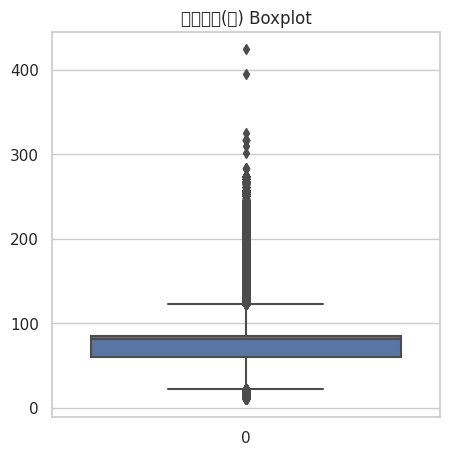

k-전체동수 Boxplot


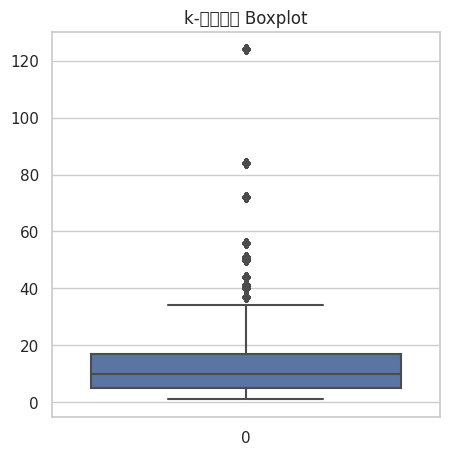

k-전체세대수 Boxplot


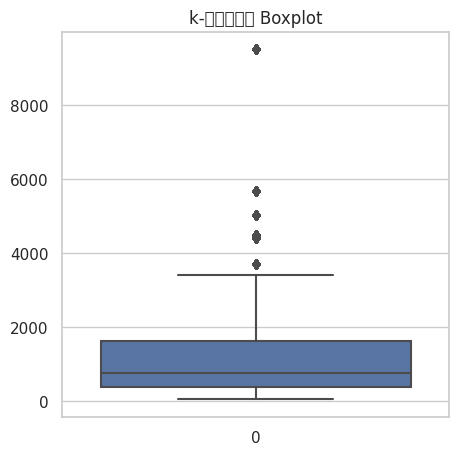

k-연면적 Boxplot


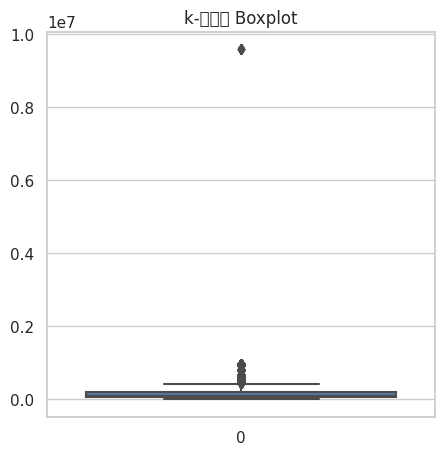

k-주거전용면적 Boxplot


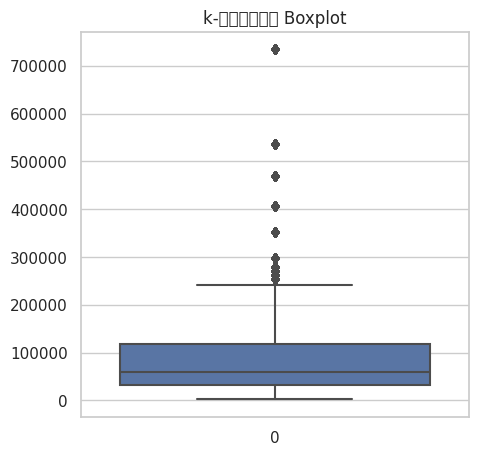

k-전용면적별세대현황(60㎡이하) Boxplot


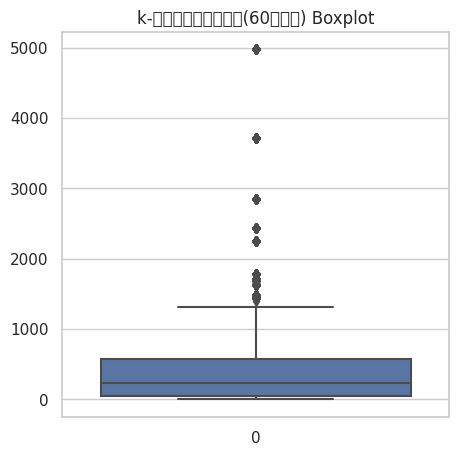

k-전용면적별세대현황(60㎡~85㎡이하) Boxplot


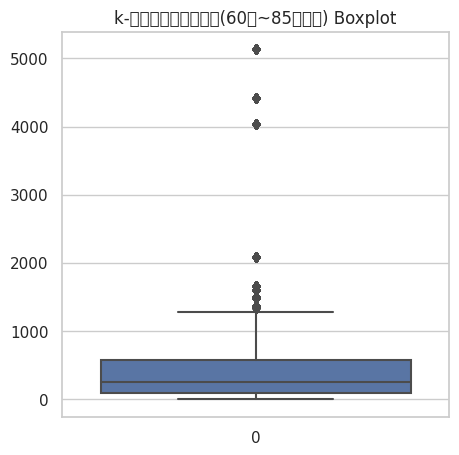

k-85㎡~135㎡이하 Boxplot


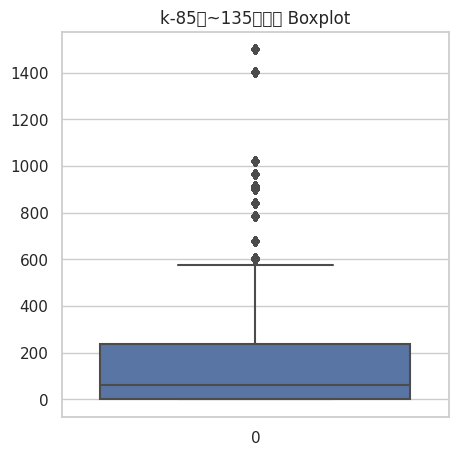

건축면적 Boxplot


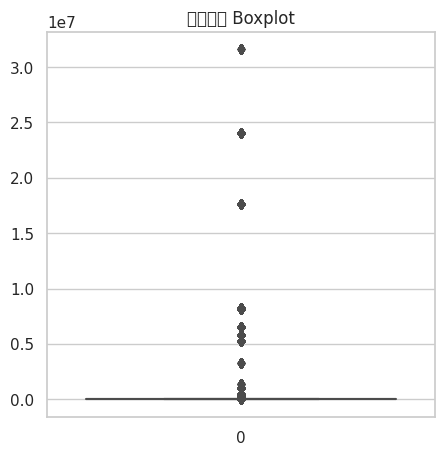

주차대수 Boxplot


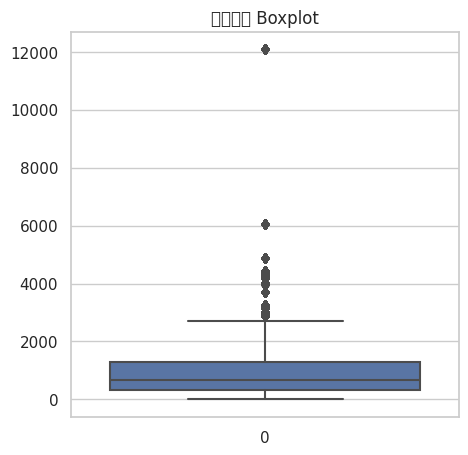

좌표X Boxplot


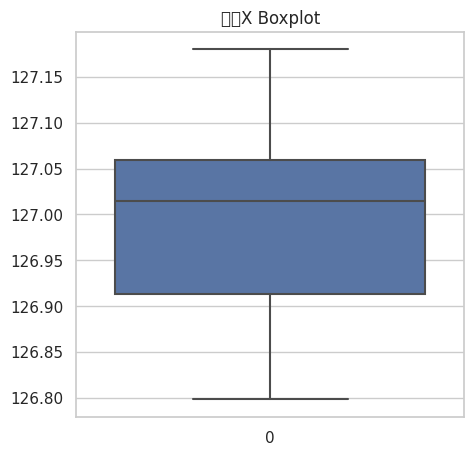

좌표Y Boxplot


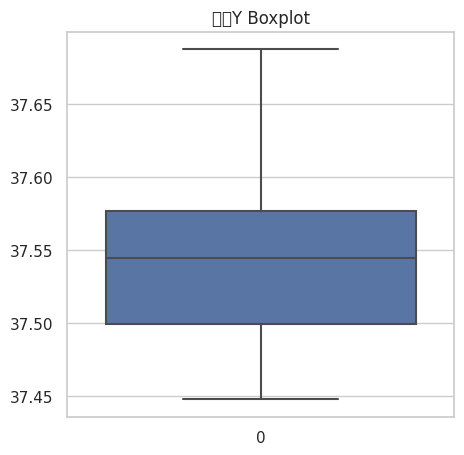

In [8]:

# 1. boxplot 확인

sns.set(style="whitegrid")

for column in num_col(except_col, date_col):
    print(f"{column} Boxplot")
    plt.figure(figsize=(5, 5))
    sns.boxplot(data=dt[column], orient='v')
    plt.title(f'{column} Boxplot')
    plt.show()



전용면적(㎡) Histogram


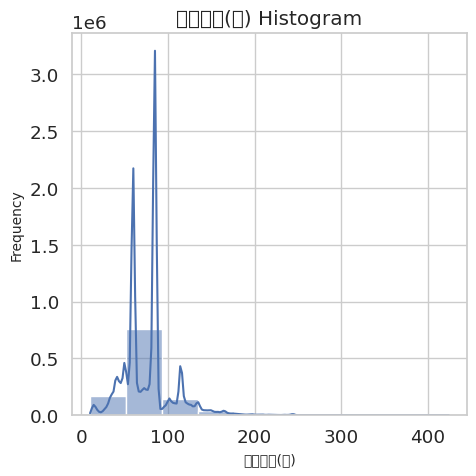

k-전체동수 Histogram


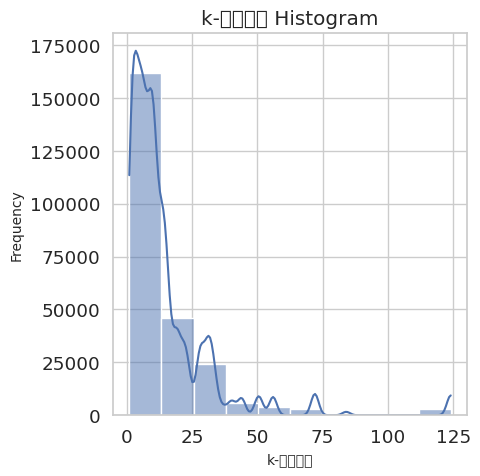

k-전체세대수 Histogram


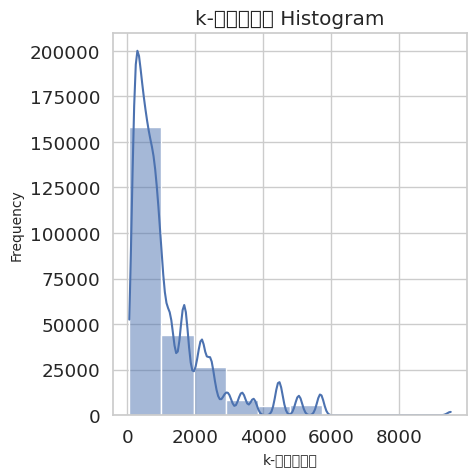

k-연면적 Histogram


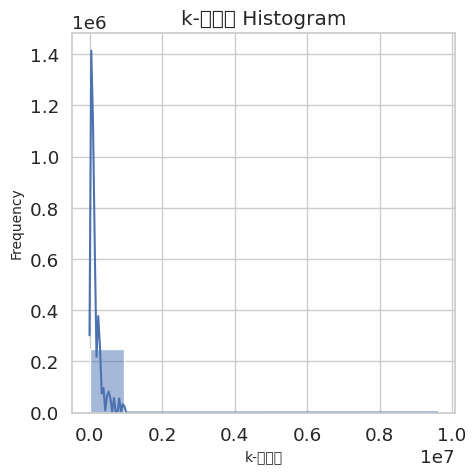

k-주거전용면적 Histogram


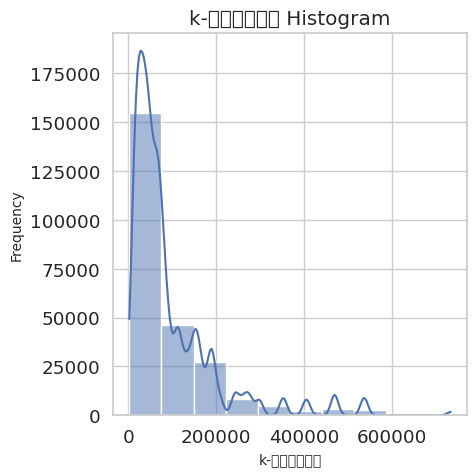

k-전용면적별세대현황(60㎡이하) Histogram


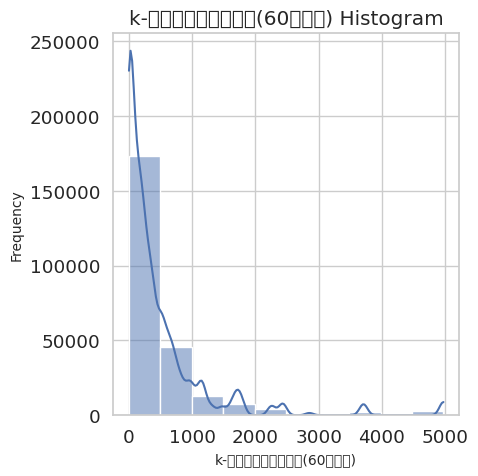

k-전용면적별세대현황(60㎡~85㎡이하) Histogram


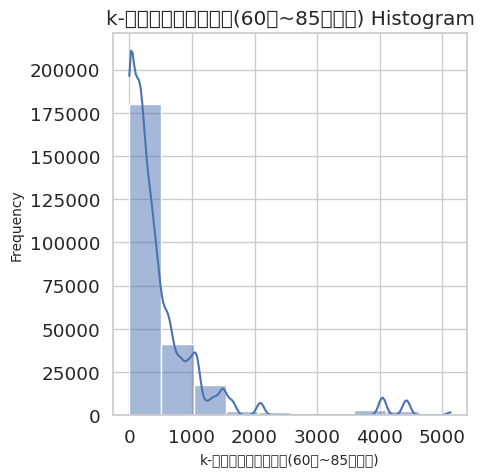

k-85㎡~135㎡이하 Histogram


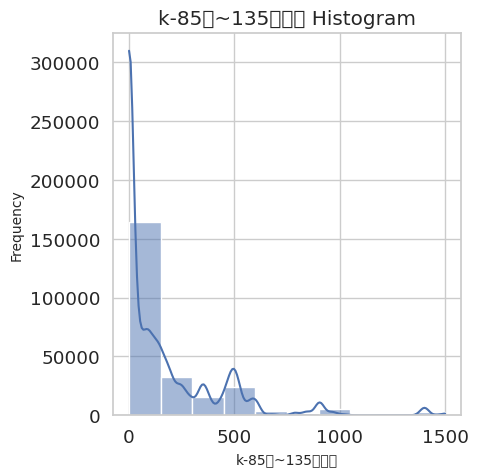

건축면적 Histogram


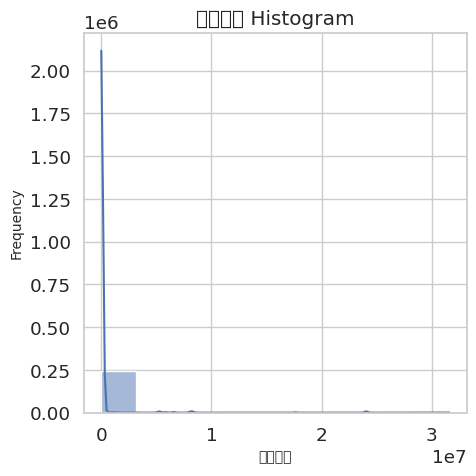

주차대수 Histogram


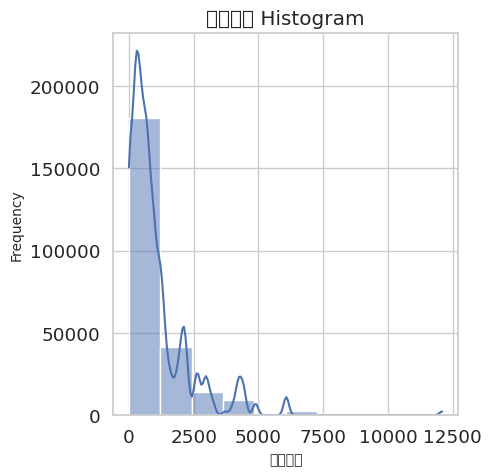

좌표X Histogram


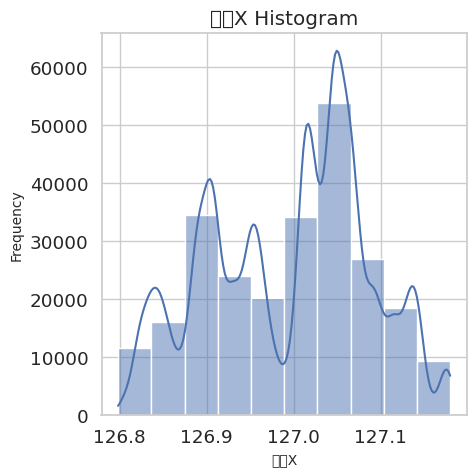

좌표Y Histogram


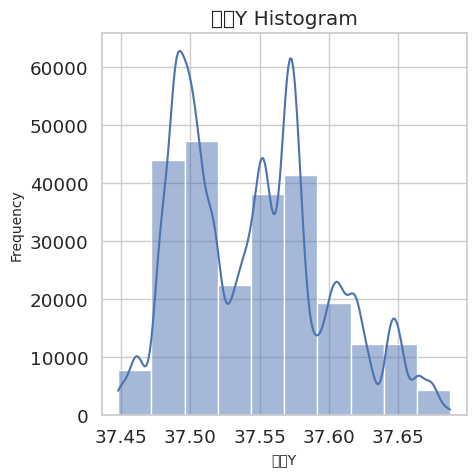

In [9]:
# 2. Histogram 확인

sns.set(style="whitegrid", font_scale=1.2)
for column in num_col(except_col, date_col):
    print(f"{column} Histogram")
    plt.figure(figsize=(5, 5))
    sns.histplot(data=dt[column], bins=10, kde=True)
    plt.title(f'{column} Histogram')
    plt.xlabel(f"{column}", size=10)
    plt.ylabel('Frequency', size=10)
    plt.tight_layout()
    plt.show()

In [ ]:
# 3. Scatter plot 확인

sns.set(style="whitegrid")
for column in num_col(except_col, date_col):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=dt, x=column, y='총면적(㎡)', hue='총면적(㎡)', size='총면적(㎡)')
    plt.title(f'{column} Scatter plot')
    plt.show()

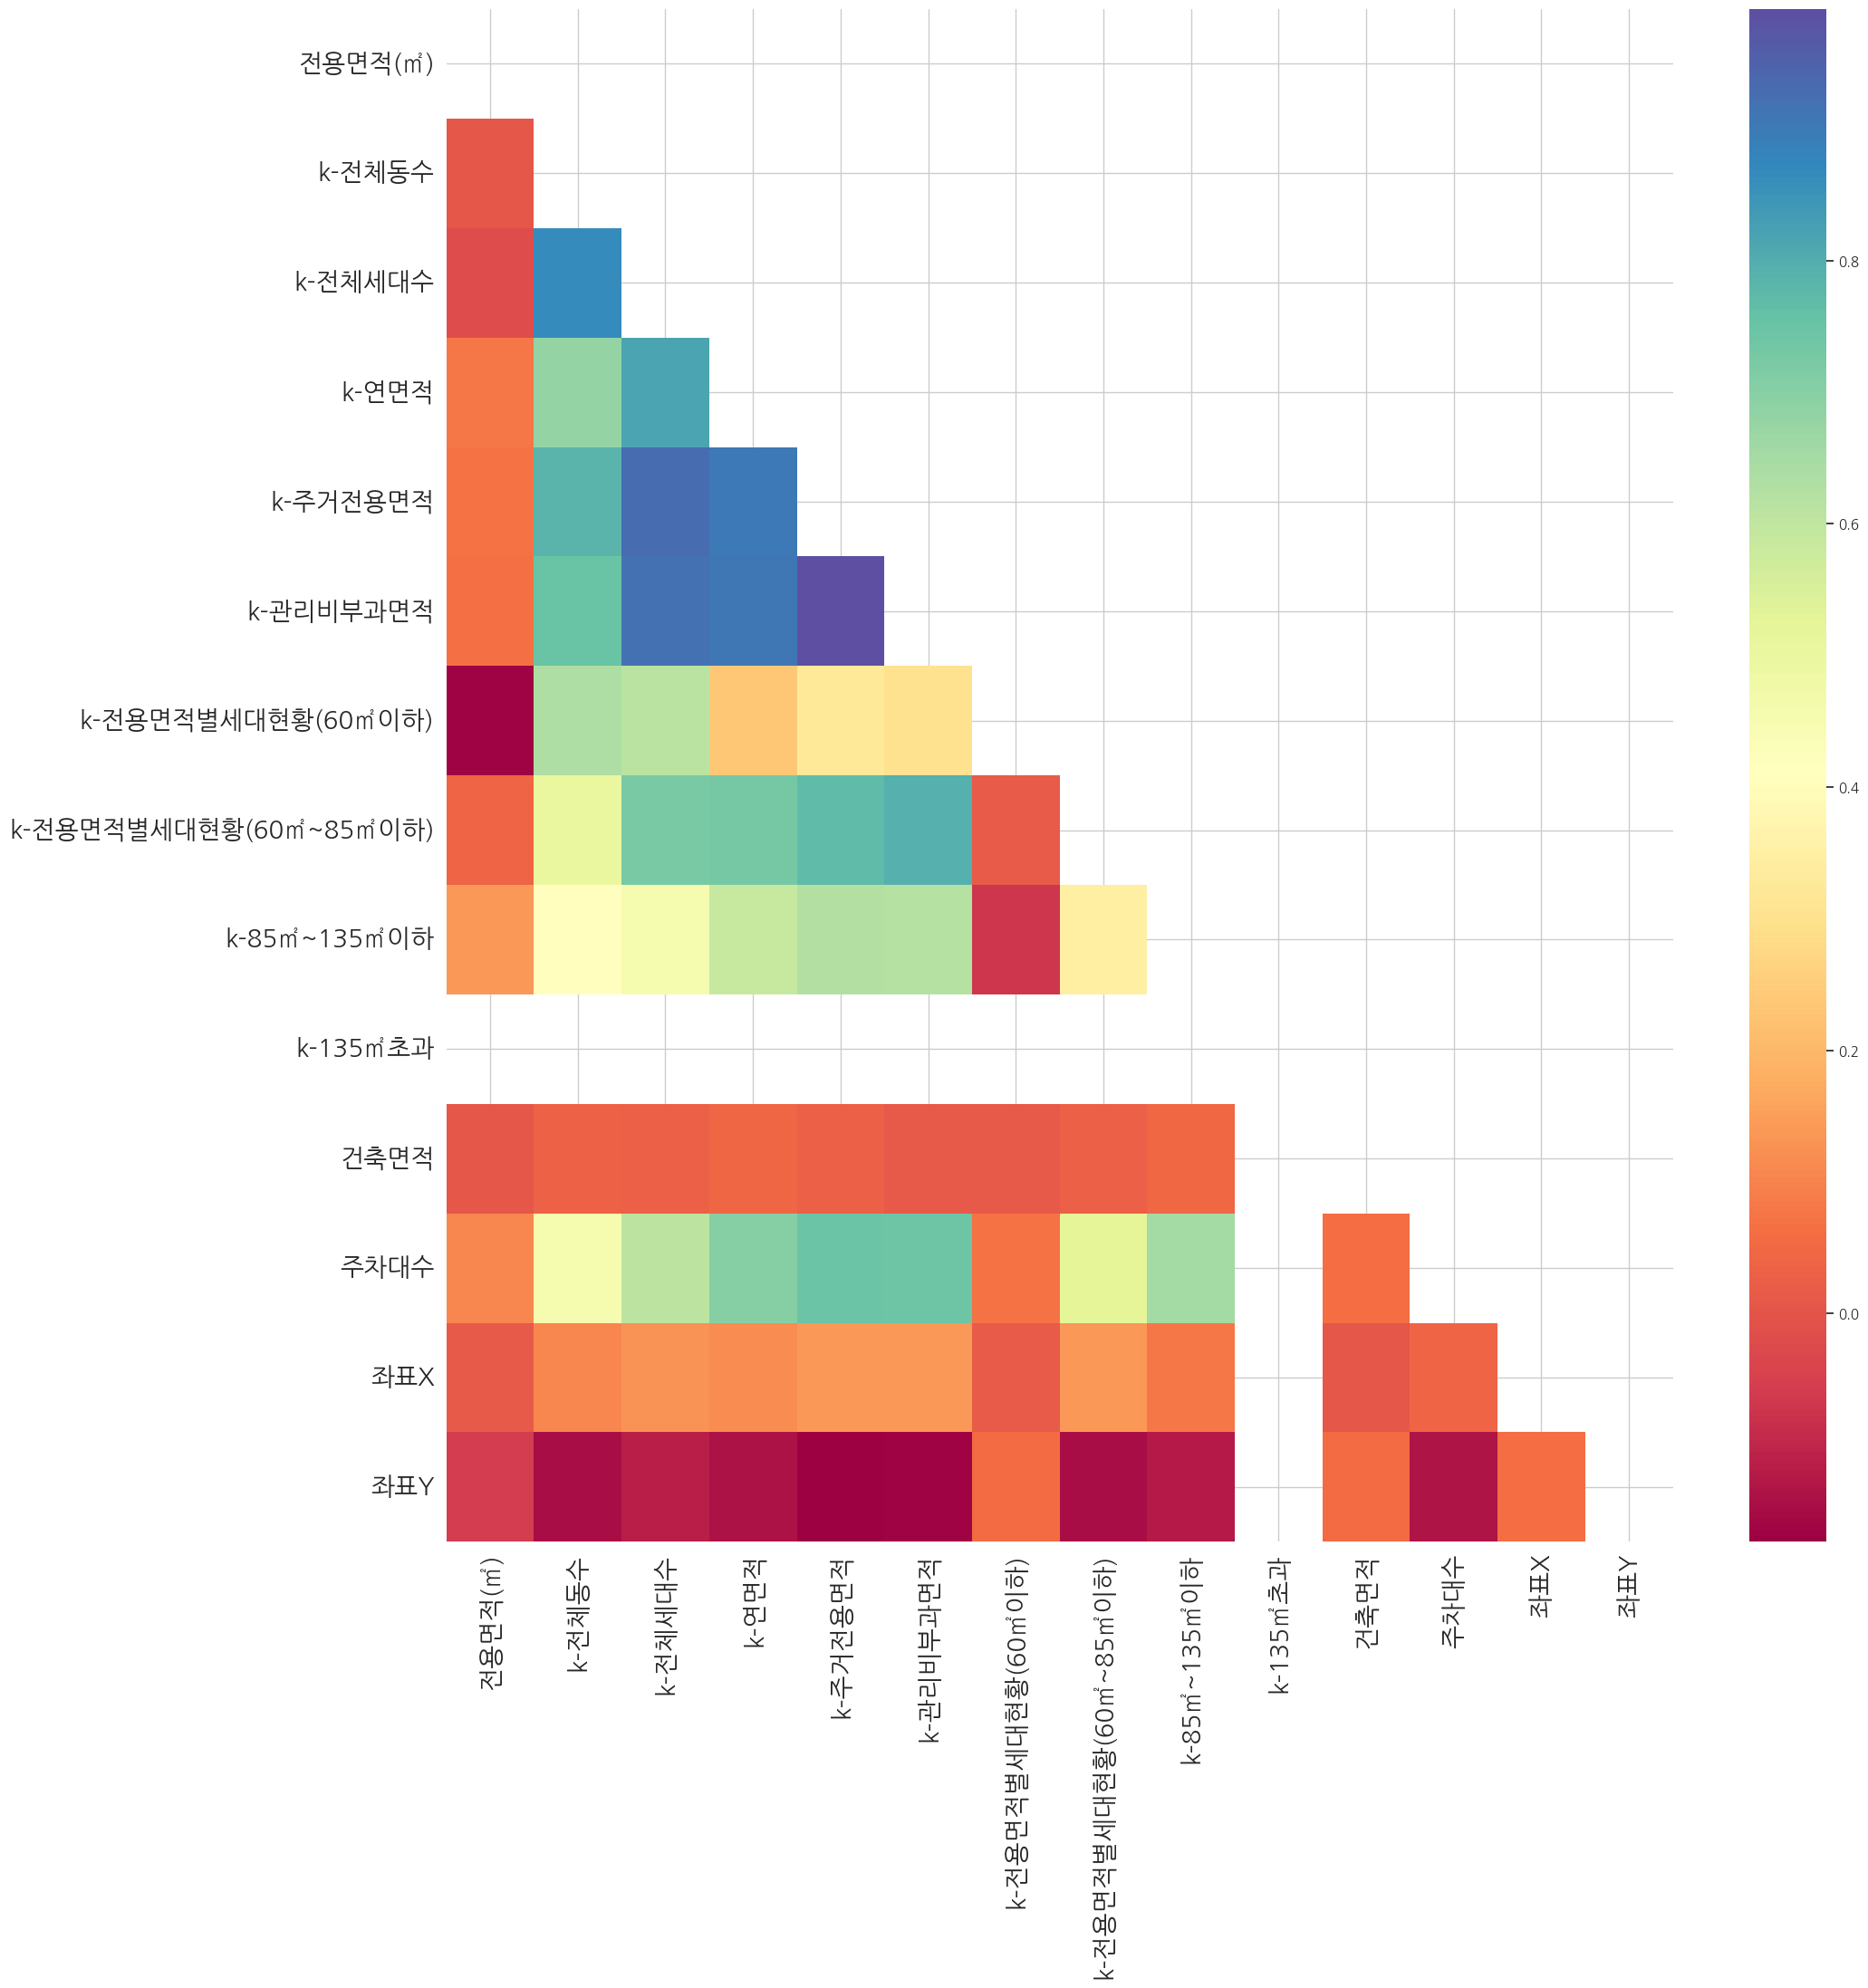

In [181]:
# 4. 상관관계 확인
plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(20, 20))
sns.heatmap(dt[numerical_columns].corr(), 
            xticklabels=numerical_columns,
            yticklabels=numerical_columns, 
            # square=True,
            cmap='Spectral',
            mask=np.triu(dt[numerical_columns].corr()))
plt.tight_layout()
plt.xticks(rotation=90, size=20)
plt.yticks(rotation=0, size=20)
plt.show()
